In [1]:
import re
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv('C:/Users/LENOVO/Downloads/train/train.csv')

In [3]:
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [4]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [6]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


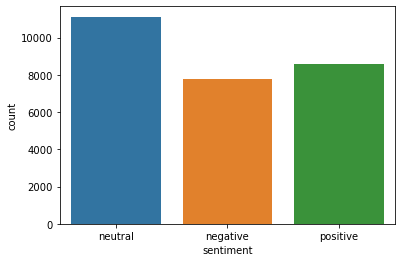

In [7]:
# Check for data imbalance
sns.countplot(train["sentiment"]);

In [8]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [9]:
#Is there any null value?
train["selected_text"].isnull().sum()

1

In [10]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

In [11]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [12]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [14]:
len(data_words)

27481

In [15]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [16]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [17]:
data = np.array(data)

In [18]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [19]:
len(labels)

27481

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [21]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [30]:
from keras.layers import Dropout

# Final evaluation of the model
# create the model
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(Dropout(0.5))
model3.add(layers.MaxPooling1D(pool_size=5))
model3.add(layers.LSTM(20))
model3.add(Dropout(0.5))
model3.add(layers.Dense(3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model3.fit(X_train, y_train, epochs=100)

Epoch 1/100
645/645 [==============================] - 13s 17ms/step - loss: 1.1486 - accuracy: 0.5201
Epoch 2/100
645/645 [==============================] - 13s 20ms/step - loss: 0.8325 - accuracy: 0.6379
Epoch 3/100
645/645 [==============================] - 14s 22ms/step - loss: 0.7130 - accuracy: 0.7460
Epoch 4/100
645/645 [==============================] - 12s 19ms/step - loss: 0.6736 - accuracy: 0.7677
Epoch 5/100
645/645 [==============================] - 12s 19ms/step - loss: 0.6441 - accuracy: 0.7814
Epoch 6/100
645/645 [==============================] - 12s 19ms/step - loss: 0.5949 - accuracy: 0.8055
Epoch 7/100
645/645 [==============================] - 13s 19ms/step - loss: 0.5537 - accuracy: 0.8254
Epoch 8/100
645/645 [==============================] - 12s 19ms/step - loss: 0.5442 - accuracy: 0.8266
Epoch 9/100
645/645 [==============================] - 13s 20ms/step - loss: 0.5283 - accuracy: 0.8349
Epoch 10/100
645/645 [==============================] - 12s 19ms/step - l

In [31]:
model3.evaluate(X_test,  y_test, verbose=2)

215/215 - 1s - loss: 0.5328 - accuracy: 0.8355


[0.5328353047370911, 0.8355406522750854]

In [32]:
yhat_classes = model3.predict_classes(X_test, verbose=0)

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

f1 = f1_score(y_test.argmax(axis=1), yhat_classes.astype(np.int),average='weighted')
print('F1 score: %f' % f1)

F1 score: 0.835838


In [56]:
recall = recall_score(y_test.argmax(axis=1), yhat_classes,average='weighted')
print('recall score: %f' % recall)

recall score: 0.835541


In [57]:
precision = precision_score(y_test.argmax(axis=1), yhat_classes,average='weighted')
print('precision score: %f' % precision)

precision score: 0.836665


In [51]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(Dropout(0.5))
model3.add(layers.MaxPooling1D(pool_size=5))
model3.add(layers.LSTM(20))
model3.add(Dropout(0.5))
model3.add(layers.Dense(3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [52]:
model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 40)           200000    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 195, 20)           4820      
_________________________________________________________________
dropout_16 (Dropout)         (None, 195, 20)           0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 39, 20)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)               

In [2]:
import pandas as pd
score = [('CNN-LSTM',0.84,.84,0.84)]
label=['Classifier','F1 Score', 'Recall_score','Precision_']

score_df = pd.DataFrame(data=score, columns=label)#.set_index('Classifier')
score_df

,Classifier,F1 Score,Recall_score,Precision_
0,CNN-LSTM,0.84,0.84,0.84
